<h2> <span style="color: Red;"> Amr Rashad | Classification Models | Bank Customer Churn Dataset </span> </h2>

## <span style="color: LightBlue;"> 0. Outline </span>

1. Perform Data Exploration (Categorical & Numerical)
2. Answer the following questions:
    - Check if the dataset suffers from imbalance
    - Check whether there exists a correlation between the numerical variables
3. Running 3 classification models to determine which one gives the most accurate prediction
4. Evaluating the models and understand which features are the most important in explaining the customer's decision to leave.

## <span style="color: IndianRed;"> 1. Loading The Dataset & Exploratory Data Analysis </span>

### <span style="color: LightSalmon;"> *1.1 Load Required Libraries:* </span>

In [430]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from statistics import mean
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [431]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,10) # Adjusts the configuration of the plots we will create

### <span style="color: LightSalmon;"> *1.2 Load Dataset:* </span>

In [432]:
Bank_Churn = pd.read_csv('Bank Customer Churn Prediction.csv')
Bank_Churn.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [433]:
#Dropping customer_id
Bank_Churn.drop(Bank_Churn.columns[[0]], axis=1, inplace=True)

### <span style="color: LightSalmon;"> *1.3 Data Exploration:* </span>

#### <span style="color: DarkYellow;"> *1.3.1 Exploring The 'churn' Distribution & Exploring The Dataset:* </span>

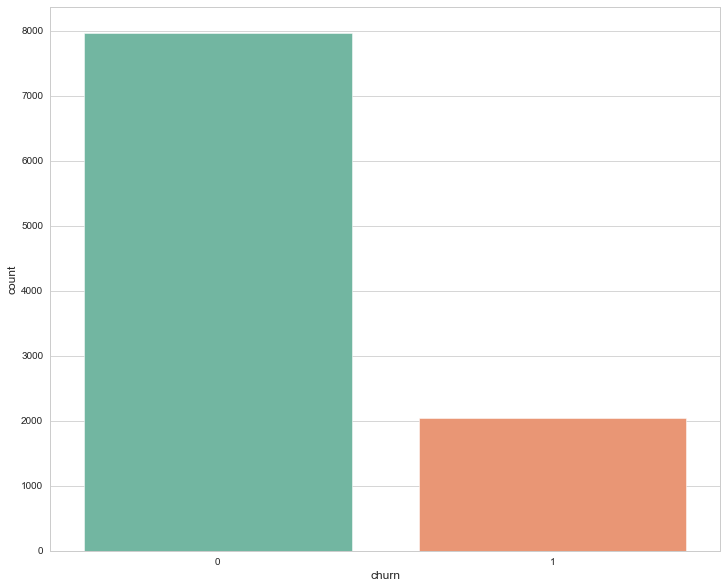

In [434]:
sns.set_style("whitegrid")
#sns.color_palette("pastel", 9)
sns.set_palette("Set2")
sns.countplot(x = 'churn', data = Bank_Churn)
 
# Show the plot
plt.show()

- It seems that our dataset is moderately imbalanced. This will be looked at more in detail when we come to running the classification models

#### <span style="color: DarkYellow;"> *1.3.2 Categorical Variables Plots:* </span>

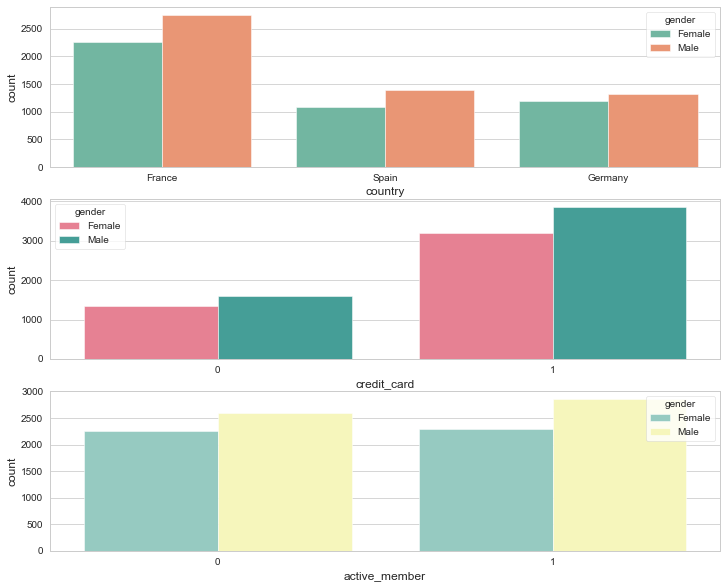

In [435]:
fig, axs = plt.subplots(nrows=3)
sns.set_style("whitegrid")
plot_1 = sns.countplot(x = 'country', hue= 'gender', palette= "Set2", ax=axs[0], data = Bank_Churn)
plot_2 = sns.countplot(x = 'credit_card', hue= 'gender', palette= "husl", ax=axs[1], data = Bank_Churn)
plot_1 = sns.countplot(x = 'active_member', hue= 'gender', palette= "Set3", ax=axs[2], data = Bank_Churn)
 
# Show the plot
plt.show()

- Interesting observation here, most of the clients who leave have credit cards.

#### <span style="color: DarkYellow;"> *1.3.3 Exploring If There Exist A Correlation Among The Numerical Variables:* </span>

In [436]:
num_vars_Bank_Churn = Bank_Churn[['credit_score', 'age', 'tenure', 'products_number', 'estimated_salary']]
num_vars_Bank_Churn.head()

,credit_score,age,tenure,products_number,estimated_salary
0,619,42,2,1,101348.88
1,608,41,1,1,112542.58
2,502,42,8,3,113931.57
3,699,39,1,2,93826.63
4,850,43,2,1,79084.10


In [437]:
corr_matrix = num_vars_Bank_Churn.corr()
print(corr_matrix)

                  credit_score       age    tenure  products_number  \
credit_score          1.000000 -0.003965  0.000842         0.012238   
age                  -0.003965  1.000000 -0.009997        -0.030680   
tenure                0.000842 -0.009997  1.000000         0.013444   
products_number       0.012238 -0.030680  0.013444         1.000000   
estimated_salary     -0.001384 -0.007201  0.007784         0.014204   

                  estimated_salary  
credit_score             -0.001384  
age                      -0.007201  
tenure                    0.007784  
products_number           0.014204  
estimated_salary          1.000000  


<AxesSubplot:>

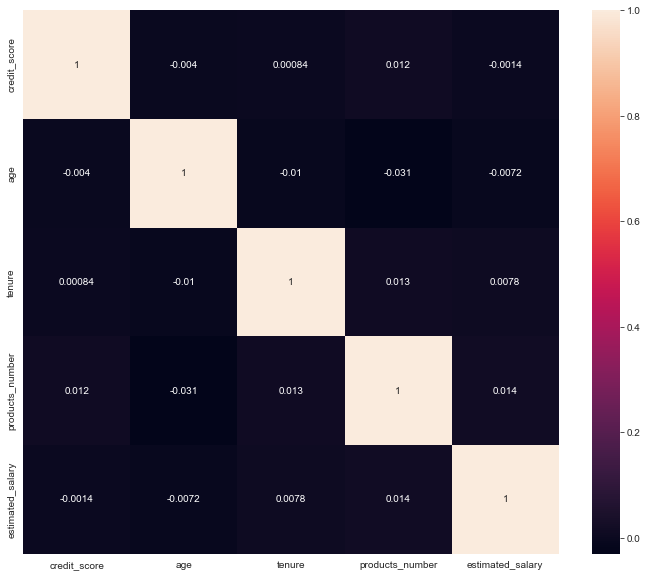

In [438]:
sns.heatmap(corr_matrix, annot=True)

- It doesn't seem to be that we're having any noticeable / significant correlation between numerical variables

### <span style="color: LightSalmon;"> *1.4 Some Interesting Plots & Inferences:* </span>

<AxesSubplot:xlabel='churn', ylabel='age'>

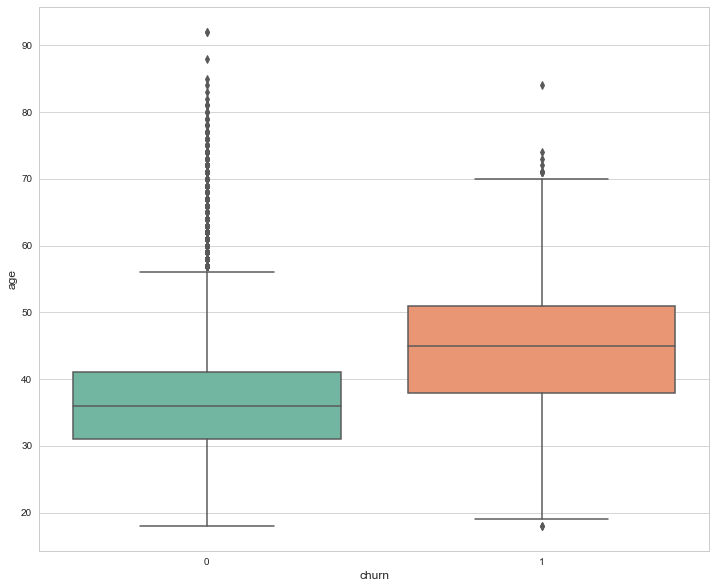

In [439]:
sns.boxplot(data=Bank_Churn, x="churn", y="age")

- Seems that the average age of customers leaving the bank is around 10 years more than the average age of customers who stay

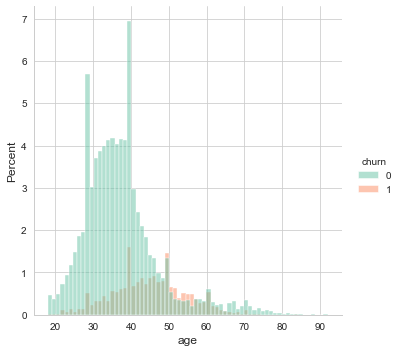

In [440]:
sns.displot(x='age', stat = 'percent', hue = 'churn', data= Bank_Churn,
                kind = 'hist', palette= "Set2")

- Seems that distribution is skewed towards young/middle aged clients, where again we can see the peak of each distribution, for instance the peak for customers who stayed is in between 30 and 40 years old, as for the customers who have left, the peak is in between 40 and 50 years old.

## <span style="color: IndianRed;"> 2. Running Various Classification Models: </span>

- Few points to discuss before applying the classification models.
    1. The dataset will be split into train and test sets, 70/30 accordingly. 
    2. The data imbalance will be dealt with through the application of Stratified k-fold cross validation.
- The classification models that will be applied are the following:
    1. Linear Discriminant Analysis
    2. Random Forest
    3. Light Gradient-Boosting Machine

### <span style="color: LightSalmon;"> *2.1 Split the data into train and test sets:* </span>

In [441]:
#creating dummy variables for the categorical variables
Bank_Churn_dum = pd.get_dummies(Bank_Churn, columns=['country', 'gender'], drop_first = True)

In [442]:
x = Bank_Churn_dum.loc[:, Bank_Churn_dum.columns !='churn']
y = Bank_Churn_dum.loc[:, Bank_Churn_dum.columns =='churn']

In [443]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

In [444]:
Test_scores = pd.DataFrame(columns=['Accuracy', 'AUC'])

### <span style="color: LightSalmon;"> *2.2 Linear Discriminant Analysis Model:* </span>

In [445]:
# Fitting the model & Performing Stratified k-fold cross validation after
lda =  LinearDiscriminantAnalysis()
lda.fit(X_train, y_train['churn'])
cv = StratifiedKFold(n_splits=10, random_state=123, shuffle= True)

In [446]:
#Evaluating the model accuracy & AUC
acc_score_train = cross_val_score(lda, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
auc_score_train = cross_val_score(lda, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('\nOverall Train Accuracy: %.2f' % (mean(acc_score_train)*100), '%')
print('\nOverall Train AUC: %.2f' % (mean(auc_score_train)*100), '%')


Overall Train Accuracy: 80.30 %

Overall Train AUC: 76.27 %


In [447]:
#Performing model prediction and getting the accuracy and AUC scores
pred = lda.predict(X_test)
pred_prob = lda.predict_proba(X_test)[:, 1]
acc_score_test = accuracy_score(y_test, pred)
auc_score_test = roc_auc_score(y_test, pred_prob)
print('\nOverall Test Accuracy: %.2f' % (acc_score_test*100), '%')
print('\nOverall Test AUC: %.2f' % (auc_score_test*100), '%')


Overall Test Accuracy: 81.67 %

Overall Test AUC: 77.93 %


In [448]:
Test_scores = Test_scores.append({"Accuracy":acc_score_test, "AUC": auc_score_test},ignore_index=True)

C:\Users\amrmn\AppData\Local\Temp\ipykernel_12212\4285009929.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_scores = Test_scores.append({"Accuracy":acc_score_test, "AUC": auc_score_test},ignore_index=True)


### <span style="color: LightSalmon;"> *2.3 Random Forest Model:* </span>

In [449]:
# Fitting the model & Performing Stratified k-fold cross validation after
rf =  RandomForestClassifier()
rf.fit(X_train, y_train['churn'])
cv = StratifiedKFold(n_splits=10, random_state=123, shuffle= True)

In [450]:
#Evaluating the model accuracy & AUC
acc_score_train = cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
auc_score_train = cross_val_score(rf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('\nOverall Train Accuracy: %.2f' % (mean(acc_score_train)*100), '%')
print('\nOverall Train AUC: %.2f' % (mean(auc_score_train)*100), '%')


Overall Train Accuracy: 85.99 %

Overall Train AUC: 84.98 %


In [451]:
#Performing model prediction and getting the accuracy and AUC scores
pred = rf.predict(X_test)
pred_prob = rf.predict_proba(X_test)[:, 1]
acc_score_test = accuracy_score(y_test, pred)
auc_score_test = roc_auc_score(y_test, pred_prob)
print('\nOverall Test Accuracy: %.2f' % (acc_score_test*100), '%')
print('\nOverall Test AUC: %.2f' % (auc_score_test*100), '%')


Overall Test Accuracy: 86.97 %

Overall Test AUC: 86.18 %


In [452]:
Test_scores = Test_scores.append({"Accuracy":acc_score_test, "AUC": auc_score_test},ignore_index=True)

C:\Users\amrmn\AppData\Local\Temp\ipykernel_12212\4285009929.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_scores = Test_scores.append({"Accuracy":acc_score_test, "AUC": auc_score_test},ignore_index=True)


### <span style="color: LightSalmon;"> *2.4 Light Gradient-Boosting Machine Model:* </span>

In [453]:
# Fitting the model & Performing Stratified k-fold cross validation after
lgbm =  lgb.LGBMClassifier()
lgbm.fit(X_train, y_train['churn'])
cv = StratifiedKFold(n_splits=10, random_state=123, shuffle= True)

In [454]:
#Evaluating the model accuracy & AUC
acc_score_train = cross_val_score(lgbm, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
auc_score_train = cross_val_score(lgbm, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('\nOverall Train Accuracy: %.2f' % (mean(acc_score_train)*100), '%')
print('\nOverall Train AUC: %.2f' % (mean(auc_score_train)*100), '%')


Overall Train Accuracy: 85.76 %

Overall Train AUC: 85.25 %


In [455]:
#Performing model prediction and getting the accuracy and AUC scores
pred = lgbm.predict(X_test)
pred_prob = lgbm.predict_proba(X_test)[:, 1]
acc_score_test = accuracy_score(y_test, pred)
auc_score_test = roc_auc_score(y_test, pred_prob)
print('\nOverall Test Accuracy: %.2f' % (acc_score_test*100), '%')
print('\nOverall Test AUC: %.2f' % (auc_score_test*100), '%')


Overall Test Accuracy: 86.77 %

Overall Test AUC: 87.38 %


In [456]:
Test_scores = Test_scores.append({"Accuracy":acc_score_test, "AUC": auc_score_test},ignore_index=True)

C:\Users\amrmn\AppData\Local\Temp\ipykernel_12212\4285009929.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_scores = Test_scores.append({"Accuracy":acc_score_test, "AUC": auc_score_test},ignore_index=True)


## <span style="color: IndianRed;"> 3. Model Evaluation & Performing Feature Importance: </span>

In [457]:
Test_scores

,Accuracy,AUC
0,0.816667,0.779349
1,0.869667,0.861827
2,0.867667,0.873756


- It seems that LGMB model provides the best test accuracy and AUC

In [458]:
importances = pd.DataFrame({'Value':lgbm.feature_importances_,'Feature':X_train.columns}).sort_values(by="Value",ascending=False)

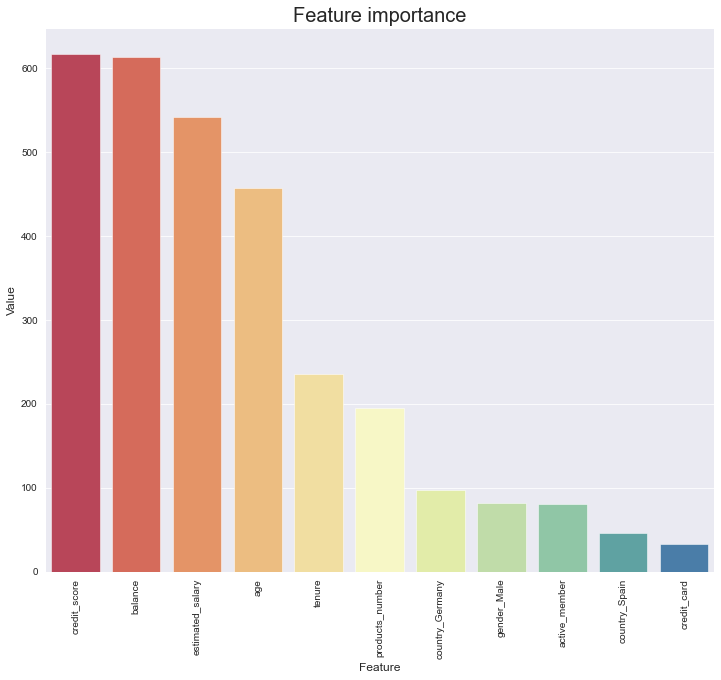

In [459]:
sns.set_style("darkgrid")
plot_6 = sns.barplot(x = importances['Feature'], y = importances['Value'], palette = 'Spectral')
plt.title('Feature importance', size=20)
plt.xticks(rotation='vertical')
plt.show(plot_6)

- The variables with the highest importance scores (the ones that give the best prediction and contribute most to the model) are:
    1. Credit Score
    2. Balance
    3. Estimated Salary
    4. Age